In [23]:
import pandas as pd

# Load the TSV files and specify column names
train_df = pd.read_csv('train.tsv', sep='\t', header=None, names=['Comment', 'Emotion', 'Comment ID'])
dev_df = pd.read_csv('dev.tsv', sep='\t', header=None, names=['Comment', 'Emotion', 'Comment ID'])
test_df = pd.read_csv('test.tsv', sep='\t', header=None, names=['Comment', 'Emotion', 'Comment ID'])

## Selecting 1 emotion label for rows having multiple

In [24]:
def split_and_duplicate_rows(df):
    df['Emotion'] = df['Emotion'].astype(str).apply(lambda x: x.split(',')[0])

    # Convert 'Emotion' column to integer
    df['Emotion'] = df['Emotion'].astype(int)

    return df

# Apply the function to each DataFrame
train_df = split_and_duplicate_rows(train_df)
dev_df = split_and_duplicate_rows(dev_df)
test_df = split_and_duplicate_rows(test_df)

# Convert the labels to integers and ensure they are of dtype long
train_df['Emotion'] = train_df['Emotion'].astype(int)
dev_df['Emotion'] = dev_df['Emotion'].astype(int)
test_df['Emotion'] = test_df['Emotion'].astype(int)

# Verify the result
print(dev_df.head())

                                             Comment  Emotion Comment ID
0  Is this in New Orleans?? I really feel like th...       27    edgurhb
1  You know the answer man, you are programmed to...        4    ee84bjg
2               I've never been this sad in my life!       25    edcu99z
3  The economy is heavily controlled and subsidiz...        4    edc32e2
4  He could have easily taken a real camera from ...       20    eepig6r


## Reducing number of emotion labels to 6 from 28

In [25]:
# Define a mapping to reduce numeric emotions from 28 to 7 categories (including neutral)
emotion_reduction_mapping = {
    # Happiness
    0: 0,  # admiration -> happiness
    1: 0,  # amusement -> happiness
    13: 0, # excitement -> happiness
    15: 0, # gratitude -> happiness
    21: 0, # pride -> happiness
    17: 0, # joy -> happiness
    18: 0, # love -> happiness
    20: 0, # optimism -> happiness
    23: 0, # relief -> happiness

    # Surprise
    22: 1, # realization -> surprise
    26: 1, # surprise -> surprise

    # Sadness
    16: 2, # grief -> sadness
    25: 2, # sadness -> sadness
    9: 2,  # disappointment -> sadness
    12: 2, # embarrassment -> sadness

    # Anger
    2: 3,  # anger -> anger
    3: 3,  # annoyance -> anger

    # Disgust
    11: 4, # disgust -> disgust
    10: 4, # disapproval -> disgust

    # Fear
    14: 5, # fear -> fear
    19: 5, # nervousness -> fear

    # Neutral
    27: 6  # neutral -> neutral
}

def reduce_emotions_numeric(df):
    # Map the emotions to the reduced categories
    df['Emotion'] = df['Emotion'].apply(lambda x: emotion_reduction_mapping.get(x, None))

    # Drop rows with unmapped or invalid emotions
    df.dropna(subset=['Emotion'], inplace=True)

    # Ensure Emotion column is of integer type
    df['Emotion'] = df['Emotion'].astype(int)

    return df

# Apply the mapping to all datasets
train_df = reduce_emotions_numeric(train_df)
dev_df = reduce_emotions_numeric(dev_df)
test_df = reduce_emotions_numeric(test_df)

# Check the results
print(train_df.head())


                                             Comment  Emotion Comment ID
0  My favourite food is anything I didn't have to...        6    eebbqej
1  Now if he does off himself, everyone will thin...        6    ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING        3    eezlygj
3                        To make her feel threatened        5    ed7ypvh
4                             Dirty Southern Wankers        3    ed0bdzj


In [26]:
# Inspect the unique values in the Emotion column
print("Train Emotion Types and Values:", train_df['Emotion'].apply(type).unique(), train_df['Emotion'].unique())
print("Dev Emotion Types and Values:", dev_df['Emotion'].apply(type).unique(), dev_df['Emotion'].unique())
print("Test Emotion Types and Values:", test_df['Emotion'].apply(type).unique(), test_df['Emotion'].unique())


Train Emotion Types and Values: [<class 'int'>] [6 3 5 1 0 2 4]
Dev Emotion Types and Values: [<class 'int'>] [6 2 0 3 4 5 1]
Test Emotion Types and Values: [<class 'int'>] [2 0 6 3 5 4 1]


In [27]:
dev_df.head()

,Comment,Emotion,Comment ID
0,Is this in New Orleans?? I really feel like th...,6,edgurhb
2,I've never been this sad in my life!,2,edcu99z
4,He could have easily taken a real camera from ...,0,eepig6r
5,"Thank you for your vote of confidence, but we ...",0,eczm50f
6,Wah Mum other people call me on my bullshit an...,3,ed4yr9r


## Data Augmentation

In [29]:
import nlpaug.augmenter.word as naw

# Define the synonym augmenter
synonym_aug = naw.SynonymAug(aug_src='wordnet')

# Function to augment data for a specific emotion
def augment_emotion_rows(df, emotion, augmenter, num_augments=2):
    # Filter rows for the specified emotion
    emotion_rows = df[df['Emotion'] == emotion].copy()
    augmented_texts = []

    # Augment each comment
    for text in emotion_rows['Comment']:
        for _ in range(num_augments):
            augmented_texts.append(augmenter.augment(text))

    # Create a new DataFrame with augmented data
    augmented_df = pd.DataFrame({
        'Comment': augmented_texts,
        'Emotion': [emotion] * len(augmented_texts)
    })

    return augmented_df

# Augment emotions 1 to 5
augmented_dfs = []
for emotion in range(1, 6):
    augmented_dfs.append(augment_emotion_rows(train_df, emotion, synonym_aug, num_augments=3))

# Combine all augmented data
augmented_data = pd.concat(augmented_dfs)

# Add augmented data to the original training dataset
train_df = pd.concat([train_df, augmented_data]).reset_index(drop=True)

# Verify the class distribution
print(train_df['Emotion'].value_counts())


Emotion
3    14740
0    12843
6    12823
4     8924
2     8860
1     5796
5     2460
Name: count, dtype: int64


## Preprocessing

In [32]:
# Updated preprocess function
import re

def preprocess(text):
    if isinstance(text, list):  # If the entry is a list, join it into a string
        text = ' '.join(text)
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to each DataFrame
train_df['Comment'] = train_df['Comment'].apply(preprocess)
dev_df['Comment'] = dev_df['Comment'].apply(preprocess)
test_df['Comment'] = test_df['Comment'].apply(preprocess)

# Drop any rows with NaN values in the Comment column
train_df.dropna()
dev_df.dropna()
test_df.dropna()


,Comment,Emotion,Comment ID
0,im really sorry about your situation although ...,2,eecwqtt
1,its wonderful because its awful at not with,0,ed5f85d
2,kings fan here good luck to you guys will be a...,0,een27c3
3,i didnt know that thank you for teaching me so...,0,eelgwd1
4,they got bored from haunting earth for thousan...,6,eem5uti
...,...,...,...
5421,easy just include name to continue to torment ...,6,edy4kl7
5422,thanks i was diagnosed with bp 1 after the hos...,0,efeeasc
5424,daddy issues name,6,efbiugo
5425,so glad i discovered that subreddit a couple m...,0,efbvgp9


In [33]:
print(train_df.head())
print(dev_df.head())
print(test_df.head())

                                             Comment  Emotion Comment ID
0  my favourite food is anything i didnt have to ...        6    eebbqej
1  now if he does off himself everyone will think...        6    ed00q6i
2                     why the fuck is bayless isoing        3    eezlygj
3                        to make her feel threatened        5    ed7ypvh
4                             dirty southern wankers        3    ed0bdzj
                                             Comment  Emotion Comment ID
0  is this in new orleans i really feel like this...        6    edgurhb
2                 ive never been this sad in my life        2    edcu99z
4  he could have easily taken a real camera from ...        0    eepig6r
5  thank you for your vote of confidence but we s...        0    eczm50f
6  wah mum other people call me on my bullshit an...        3    ed4yr9r
                                             Comment  Emotion Comment ID
0  im really sorry about your situation although ..

## Plotting a graph to see value distribution in the dataset

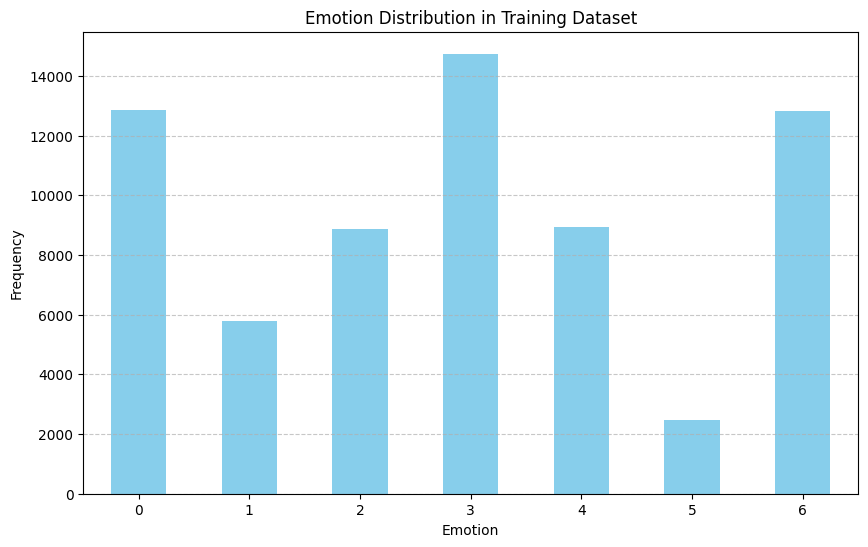

In [34]:
import matplotlib.pyplot as plt

# Assuming train_df is already loaded and contains an 'Emotion' column
plt.figure(figsize=(10, 6))
train_df['Emotion'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution in Training Dataset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Pip installing packages

In [8]:
!pip install transformers torch

In [16]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.5 MB/s eta 0:00:00


## Model Tokenizing and Training

In [35]:
from transformers import BertTokenizer

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_df['Comment'].tolist(), truncation=True, padding=True)
dev_encodings = tokenizer(dev_df['Comment'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['Comment'].tolist(), truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [36]:
import torch

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are torch.long
        return item

    def __len__(self):
        return len(self.labels)

# Convert the labels to a list or a NumPy array before creating the datasets
train_labels = train_df['Emotion'].tolist()  # or train_df['Emotion'].values for NumPy array
dev_labels = dev_df['Emotion'].tolist()
test_labels = test_df['Emotion'].tolist()

# Create datasets
train_dataset = EmotionDataset(train_encodings, train_labels)
dev_dataset = EmotionDataset(dev_encodings, dev_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)


In [38]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import pickle
from transformers import TrainerCallback

# Load BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=28)

# Custom Callback to save model after each epoch
class SaveModelCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        epoch = int(state.epoch)
        model_path = f'/content/model2_epoch_{epoch}.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved at {model_path}")

# Updated training arguments
training_args = TrainingArguments(
    output_dir='./results',             # Directory for model checkpoints
    evaluation_strategy="epoch",       # Evaluate at the end of each epoch
    learning_rate=1e-5,                # Slightly increased learning rate for faster convergence
    per_device_train_batch_size=16,    # Reduced batch size if memory constraints arise
    per_device_eval_batch_size=16,     # Matching eval batch size to train batch size
    num_train_epochs=5,               # Adjusted to prevent overfitting; consider early stopping
    weight_decay=0.01,                 # Standard weight decay for regularization
    save_strategy="epoch",             # Save checkpoints after each epoch
    save_total_limit=3,                # Keep only the last 3 checkpoints
    logging_dir='./logs',              # Directory for logs
    logging_steps=50,                  # Log more frequently for closer monitoring
    warmup_steps=300,                  # Reduce warmup steps for smoother learning rate ramp
    lr_scheduler_type="cosine",        # Use a cosine schedule for learning rate decay
    load_best_model_at_end=True,       # Automatically load the best model after training
    metric_for_best_model="eval_loss", # Use evaluation loss to determine the best model
    gradient_accumulation_steps=2,     # Accumulate gradients for larger effective batch size                       # Use mixed precision training for faster computation
    seed=42                            # Seed for reproducibility
)

trainer = Trainer(
    model=model,                          # Your model instance
    args=training_args,                   # Training arguments
    train_dataset=train_dataset,          # Training dataset
    eval_dataset=dev_dataset,            # Evaluation dataset
    tokenizer=tokenizer,                  # Tokenizer for preprocessing
    callbacks=[SaveModelCallback()],      # Add the custom callback to save models
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,0.917300,0.833718
2,0.574700,0.909469
4,0.397800,0.957113


Model saved at /content/model2_epoch_0.pkl
Model saved at /content/model2_epoch_2.pkl
Model saved at /content/model2_epoch_2.pkl
Model saved at /content/model2_epoch_4.pkl
Model saved at /content/model2_epoch_4.pkl


TrainOutput(global_step=10380, training_loss=0.700795617498644, metrics={'train_runtime': 3169.8707, 'train_samples_per_second': 104.809, 'train_steps_per_second': 3.275, 'total_flos': 2.031675484811347e+16, 'train_loss': 0.700795617498644, 'epoch': 4.998796051047435})

In [39]:
from torch.utils.data import DataLoader

model.eval()

train_loader = DataLoader(train_dataset, batch_size = 16)

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in train_loader:
        # Move input data to the appropriate device
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['labels'].to('cuda' if torch.cuda.is_available() else 'cpu')

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to predicted labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        # Store true and predicted labels
        true_labels.extend(true)
        predicted_labels.extend(preds)



## Precision Metrics

In [40]:
from sklearn.metrics import classification_report

# Generate a classification report (precision, recall, f1-score, support)
report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(7)])  # Adjust if needed
print(report)

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     12843
           1       0.67      0.66      0.66      5796
           2       0.78      0.60      0.68      8860
           3       0.74      0.71      0.72     14740
           4       0.58      0.67      0.62      8924
           5       0.71      0.70      0.70      2460
           6       0.71      0.78      0.74     12823

    accuracy                           0.73     66446
   macro avg       0.72      0.71      0.72     66446
weighted avg       0.74      0.73      0.73     66446



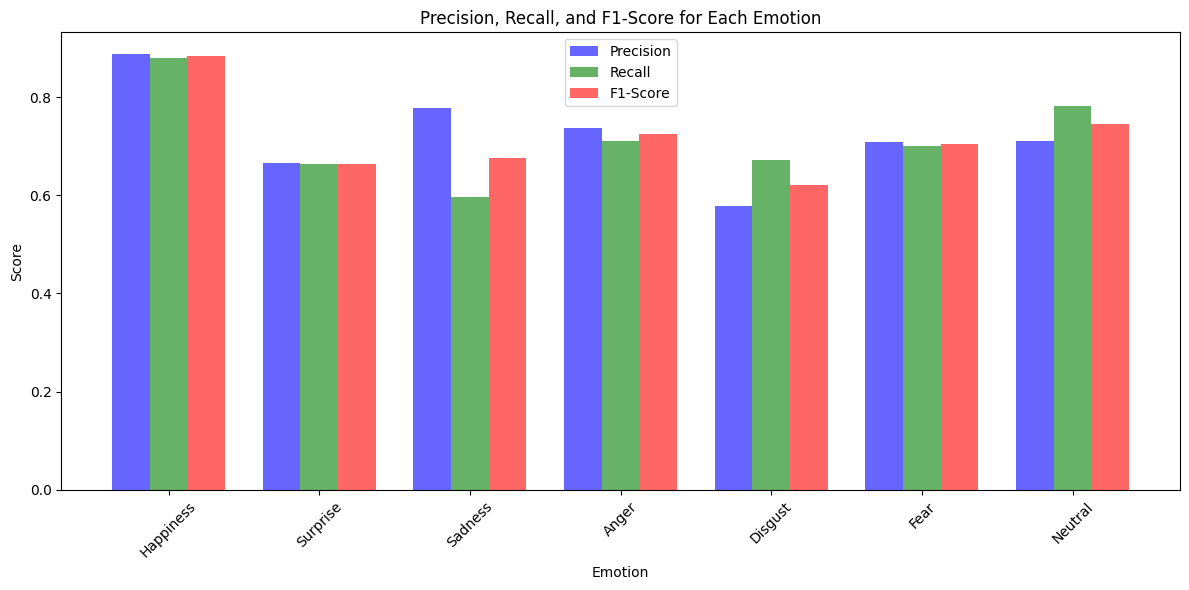

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

emotion_labels = [
    "Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear", "Neutral"
]
# Calculate precision, recall, and f1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=range(len(emotion_labels)))

# Create a bar plot
x = range(len(precision))  # Number of classes

plt.figure(figsize=(12, 6))
bar_width = 0.25  # Adjust for spacing between bars
plt.bar([i - bar_width for i in x], precision, width=bar_width, alpha=0.6, label='Precision', color='b')
plt.bar(x, recall, width=bar_width, alpha=0.6, label='Recall', color='g')
plt.bar([i + bar_width for i in x], f1, width=bar_width, alpha=0.6, label='F1-Score', color='r')
plt.xlabel('Emotion')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Emotion')
plt.xticks(x, emotion_labels, rotation=45)  # Use emotion labels instead of numeric labels
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


## Saving the Model as a pickle file

In [44]:
import torch
import pickle
from transformers import BertForSequenceClassification

# Example: Assume `model` is your fine-tuned BERT model
model_path = '/content/final_emotion_model.pkl'

# Save the model
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {model_path}")


Model saved to /content/final_emotion_model.pkl
